In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math 
import json 
import time 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import NearestNeighbors

import scipy.sparse 
from scipy.sparse import csr_matrix
import warnings ; warnings.simplefilter('ignore')
%matplotlib inline 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...
568453,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,5,1338422400,Great Honey,"I am very satisfied ,product is as advertised,..."


In [5]:
rows, columns = df.shape 
print("No. of rows:", rows)
print("No. of columns:", columns)

No. of rows: 568454
No. of columns: 10


In [6]:
df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [7]:
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [8]:
df[['Score']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Score,568454.0,4.183199,1.310436,1.0,4.0,5.0,5.0,5.0


In [9]:
def find_min_max_rating(): 
    print('The minimum rating is: %d' %(df['Score'].min()))
    print('The maximum rating is: %d' %(df['Score'].max()))
    
find_min_max_rating()

The minimum rating is: 1
The maximum rating is: 5


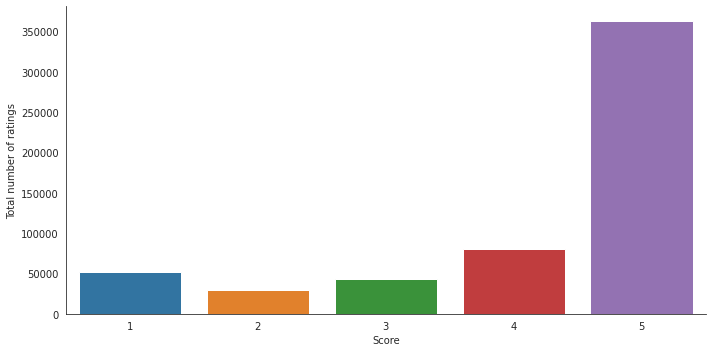

In [11]:
with sns.axes_style('white'): 
    g = sns.factorplot("Score", data = df, aspect = 2.0, kind = 'count')
    g.set_ylabels("Total number of ratings")

In [10]:
print('Number of unique USERS in Raw data =', df['UserId'].nunique())
print('Number of unique ITEMS in Raw data =', df['ProductId'].nunique())

Number of unique USERS in Raw data = 256059
Number of unique ITEMS in Raw data = 74258


In [12]:
most_rated = df.groupby('UserId').size().sort_values(ascending = False)[:10]
most_rated

UserId
A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
A1TMAVN4CEM8U8    204
A2MUGFV2TDQ47K    201
A3TVZM3ZIXG8YW    199
A3PJZ8TU8FDQ1K    178
AQQLWCMRNDFGI     176
dtype: int64

In [13]:
counts = df['UserId'].value_counts()
df_final = df[df['UserId'].isin(counts[counts >= 50].index)]

In [14]:
df_final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
44,45,B001EO5QW8,A2G7B7FKP2O2PU,D. Leschke,0,0,5,1209686400,Great taste and convenience,We really like the McCann's steel cut oats but...
46,47,B001EO5QW8,AQLL2R1PPR46X,grumpyrainbow,0,0,5,1192752000,good,Good oatmeal. I like the apple cinnamon the b...
109,110,B001REEG6C,AY12DBB0U420B,Gary Peterson,0,0,5,1316390400,My Idea of a Good Diet Food.,I'm presently on a diet and I was at my Fresh ...
141,142,B001GVISJW,A2YIO225BTKVPU,"Angel_Boy ""Treat the people around you the wa...",0,0,4,1301788800,Good Licorice,Twizzlers brand licorice is much better than t...


In [15]:
print('Number of users who have rated 50 or more items = ', len(df_final))
print('Number of unique USERS in final data = ', df_final['UserId'].nunique())
print('Number of unique ITEMS in final data = ', df_final['ProductId'].nunique())

Number of users who have rated 50 or more items =  22941
Number of unique USERS in final data =  267
Number of unique ITEMS in final data =  11313


DENSITY OF THE RATING MATRIX 

In [16]:
final_ratings_matrix = pd.pivot_table(df_final, index = ['UserId'], columns = 'ProductId', values = "Score")
final_ratings_matrix.fillna(0, inplace = True)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings / possible_num_of_ratings)
density *= 100
print('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (267, 11313)
given_num_of_ratings =  20829
possible_num_of_ratings =  3020571
density: 0.69%


In [17]:
final_ratings_matrix.tail()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
UserId,,,,,,,,,,,,,,,,,,,,,
AY1EF0GOH80EK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYB4ELCS5AM8P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYGJ96W5KQMUJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYOMAHLWRQHUG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZV26LP92E6WU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

UserId,A100WO06OQR8BQ,A106ZCP7RSXMRU,A1080SE9X3ECK0,A10G136JEISLVR,A11ED8O95W2103,A11OTLEDSW8ZXD,A12ENBT314RFXR,A132ETQPMHQ585,A13GZCHAMKWYBT,A13HRSMJ5TOWEZ,...,ATJN4KEHJBOC8,AVFA1JB08RG8G,AWKZAUC0D8DYL,AXO4PQU0XG3TG,AY12DBB0U420B,AY1EF0GOH80EK,AYB4ELCS5AM8P,AYGJ96W5KQMUJ,AYOMAHLWRQHUG,AZV26LP92E6WU
ProductId,,,,,,,,,,,,,,,,,,,,,
7310172001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7310172101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7800648702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004CI84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
B00004CXX9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [19]:
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state = 0)
print(train_data.head(5))

            Id   ProductId          UserId  \
399863  399864  B002IEVJRY  A1N5FSCYN4796F   
20262    20263  B001BDDTB2  A1Q7A78VSQ5GQ4   
139611  139612  B001BCXTGS  A2PNOU7NXB1JE4   
455504  455505  B005HG9ERW  A2SZLNSI5KOQJT   
512008  512009  B0028PDER6   ALSAOZ1V546VT   

                                        ProfileName  HelpfulnessNumerator  \
399863    Philip R. Heath "Gadgets, Music, & Books"                     0   
20262               Nice Lady "a reasonable person"                     0   
139611                               Peggy "pab920"                     0   
455504   Carrie, "Formerly &#34;Sister Carrie&#34;"                     1   
512008  A Research It Maven "Just the facts please"                     2   

        HelpfulnessDenominator  Score        Time  \
399863                       0      3  1338508800   
20262                        0      5  1229990400   
139611                       0      3  1229385600   
455504                       1      3  134766720

In [20]:
def shape(): 
    print("Test data shape: ", test_data.shape)
    print("Train data shape: ", train_data.shape)
shape()

Test data shape:  (6883, 10)
Train data shape:  (16058, 10)


BUILD POPULARITY RECOMMENDER MODEL

In [21]:
train_data_grouped = train_data.groupby('ProductId').agg({'UserId' : 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId' : 'score'}, inplace = True)
train_data_grouped.head()

,ProductId,score
0,7310172001,5
1,7310172101,5
2,7800648702,1
3,B00004CI84,2
4,B00004CXX9,3


In [22]:
train_data_sort = train_data_grouped.sort_values(['score', 'ProductId'], ascending = [0,1])
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending = 0, method = 'first')

popularity_recommendations = train_data_sort.head(5)
popularity_recommendations

,ProductId,score,Rank
5621,B002IEZJMA,48,1.0
8130,B006MONQMC,42,2.0
5620,B002IEVJRY,41,3.0
6779,B0041NYV8E,39,4.0
7876,B005HG9ET0,39,5.0


In [23]:
def recommend(user_id): 
    user_recommendations = popularity_recommendations
    
    user_recommendations['UserId'] = user_id
    
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]
    
    return user_recommendations 

In [24]:
find_recom = [15,121,200]
for i in find_recom : 
    print("Here is the recommendation for the UserId: %d\n " %(i))
    print(recommend(i))
    print("\n")

Here is the recommendation for the UserId: 15
 
      UserId   ProductId  score  Rank
5621      15  B002IEZJMA     48   1.0
8130      15  B006MONQMC     42   2.0
5620      15  B002IEVJRY     41   3.0
6779      15  B0041NYV8E     39   4.0
7876      15  B005HG9ET0     39   5.0


Here is the recommendation for the UserId: 121
 
      UserId   ProductId  score  Rank
5621     121  B002IEZJMA     48   1.0
8130     121  B006MONQMC     42   2.0
5620     121  B002IEVJRY     41   3.0
6779     121  B0041NYV8E     39   4.0
7876     121  B005HG9ET0     39   5.0


Here is the recommendation for the UserId: 200
 
      UserId   ProductId  score  Rank
5621     200  B002IEZJMA     48   1.0
8130     200  B006MONQMC     42   2.0
5620     200  B002IEVJRY     41   3.0
6779     200  B0041NYV8E     39   4.0
7876     200  B005HG9ET0     39   5.0




In [25]:
print('Since this is a popularity-based recommender model, recommendations remain the same for all users')
print('\nWe predict the products based on the popularity. It is not personalized to particular user')

Since this is a popularity-based recommender model, recommendations remain the same for all users

We predict the products based on the popularity. It is not personalized to particular user


BUILD COLLABORATIVE FILTERING MODEL

In [26]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.tail()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22936,275741,275742,B001M23WVY,AY1EF0GOH80EK,Natasha Stryker,0,0,2,1350950400,"Taste like metal, 4 of 6 cans badly dented",I was not happy with these art heart bottoms. ...
22937,281102,281103,B002R8SLUY,A16AXQ11SZA8SQ,"MamaBear007 ""MamaBear007""",6,6,5,1268179200,My dogs dance for these treats!,A dear friend sent these to my dogs as a gift....
22938,205589,205590,B00473PVVO,A281NPSIMI1C2R,"Rebecca of Amazon ""The Rebecca Review""",0,0,5,1320451200,Coconut Custard Pie,If you still have the June 2011 issue of Famil...
22939,303238,303239,B0002DGRZC,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",1,1,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
22940,36703,36704,B000EEWZD2,A2M9D9BDHONV3Y,A. Bennett,1,1,3,1206230400,Tasty but overcooked!,I like to make a quick salad using these tiny ...


In [27]:
pivot_df = pd.pivot_table(df_CF, index = ['UserId'], columns = 'ProductId', values = "Score")
pivot_df.fillna(0, inplace = True)
print(pivot_df.shape)
pivot_df.head()

(267, 11313)


ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A106ZCP7RSXMRU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4,user_index
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A106ZCP7RSXMRU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [29]:
pivot_df.set_index(['user_index'], inplace = True)

pivot_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


SVD METHOD

In [30]:
from scipy.sparse.linalg import svds 
U, sigma, Vt = svds(pivot_df, k = 50)
sigma = np.diag(sigma)

In [31]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
0,-0.023781,-0.023781,-0.002054,0.104898,0.104898,0.024303,0.107537,0.104898,-0.020275,-0.059207,...,0.046674,0.046674,0.016852,0.046674,-0.017740,0.097006,0.083491,0.076254,-0.057970,0.057460
1,-0.007905,-0.007905,-0.003851,-0.008111,-0.008111,-0.000537,-0.010274,-0.008111,-0.000594,0.032172,...,-0.028196,-0.028196,0.040836,-0.028196,0.002385,0.027653,0.566969,-0.027474,0.009181,0.000949
2,0.002045,0.002045,0.021680,0.053874,0.053874,-0.005837,-0.008159,0.053874,-0.046556,0.006265,...,-0.072355,-0.072355,0.038650,-0.072355,-0.047259,0.014912,-0.038054,0.122540,0.068785,0.021741
3,0.000029,0.000029,-0.000028,0.000039,0.000039,-0.000002,-0.000218,0.000039,0.000419,0.000130,...,0.000046,0.000046,0.000019,0.000046,0.000292,-0.000033,0.000224,-0.000047,0.000142,0.000023
4,0.006935,0.006935,-0.000392,0.008952,0.008952,-0.000043,0.012956,0.008952,-0.007402,0.004274,...,0.014244,0.014244,0.011886,0.014244,-0.000456,0.006861,0.045682,-0.000051,-0.007725,-0.015513


In [32]:
def recommend_items(userID, pivot_df, preds_df, num_recommendations): 
    
    user_idx = userID-1
    
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending = False)
    
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending = False)
    
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis = 1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending = False)
    print('\nBelow are recommended items for user(user_id = {}): \n'.format(userID))
    print(temp.head(num_recommendations))

In [33]:
userID = 121 
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are recommended items for user(user_id = 121): 

                   user_ratings  user_predictions
Recommended Items                                
B004E4EBMG                  0.0          1.553272
B004JGQ15E                  0.0          0.972833
B0061IUIDY                  0.0          0.923977
B0041NYV8E                  0.0          0.901132
B001LG940E                  0.0          0.893659


EVALUATE BOTH MODELS 

In [34]:
final_ratings_matrix.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A106ZCP7RSXMRU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
final_ratings_matrix.mean().head()

ProductId
7310172001    0.037453
7310172101    0.037453
7800648702    0.018727
B00004CI84    0.044944
B00004CXX9    0.044944
dtype: float64

In [37]:
preds_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
0,-0.023781,-0.023781,-0.002054,0.104898,0.104898,0.024303,0.107537,0.104898,-0.020275,-0.059207,...,0.046674,0.046674,0.016852,0.046674,-0.017740,0.097006,0.083491,0.076254,-0.057970,0.057460
1,-0.007905,-0.007905,-0.003851,-0.008111,-0.008111,-0.000537,-0.010274,-0.008111,-0.000594,0.032172,...,-0.028196,-0.028196,0.040836,-0.028196,0.002385,0.027653,0.566969,-0.027474,0.009181,0.000949
2,0.002045,0.002045,0.021680,0.053874,0.053874,-0.005837,-0.008159,0.053874,-0.046556,0.006265,...,-0.072355,-0.072355,0.038650,-0.072355,-0.047259,0.014912,-0.038054,0.122540,0.068785,0.021741
3,0.000029,0.000029,-0.000028,0.000039,0.000039,-0.000002,-0.000218,0.000039,0.000419,0.000130,...,0.000046,0.000046,0.000019,0.000046,0.000292,-0.000033,0.000224,-0.000047,0.000142,0.000023
4,0.006935,0.006935,-0.000392,0.008952,0.008952,-0.000043,0.012956,0.008952,-0.007402,0.004274,...,0.014244,0.014244,0.011886,0.014244,-0.000456,0.006861,0.045682,-0.000051,-0.007725,-0.015513


In [38]:
preds_df.mean().head()

ProductId
7310172001    0.001174
7310172101    0.001174
7800648702    0.004557
B00004CI84    0.039487
B00004CXX9    0.039487
dtype: float64

In [39]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis = 1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(11313, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ProductId,,,
7310172001,0.037453,0.001174,0
7310172101,0.037453,0.001174,1
7800648702,0.018727,0.004557,2
B00004CI84,0.044944,0.039487,3
B00004CXX9,0.044944,0.039487,4


In [40]:
RMSE = round ((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5) 
print('\nRMSE SVD model = {}\n'.format(RMSE))


RMSE SVD model = 0.00995



In [41]:
userID = 200 
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are recommended items for user(user_id = 200): 

                   user_ratings  user_predictions
Recommended Items                                
B004BKLHOS                  0.0          0.823791
B0061IUIDY                  0.0          0.622365
B004JRO1S2                  0.0          0.538305
B0061IUKDM                  0.0          0.534249
B002DZIL24                  0.0          0.529929
